# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 

Another idea is to use adapter finetuning ?

Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.


---
### Loss function: 
We use combination of the following: 
- DiceLoss
- FocalLoss
- BCEWithLogitsLoss
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


TODO: 

- IMPLEMENT LR SCHEDULE AND STOPPING CRITERIA
- CHECK OUT OTHER DECODERS SegFormer, MLP ... 
- CHECK OUT TO TRAIN MORE LAYERS OF TRANSFORMER

# Novel Ideas:

- LOOK AT VIT ARCHITECTURE
- TRAIN FROM SCRATCH, VARIE SOMETHING WITH LOCAL/GLOBAL ATTENTION or try some COMBINATION RESIDUAL/SKIP CONNECTIONS.



In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc","zurich","philadelphia"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"]#[0:200]
custom_data["masks"] = custom_data["masks"]#[0:200]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))
print("custom ds with ignore under threshold: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"],min_ratio_threshold=0.03))
# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

using device: mps
the raw custom dataset contains 9208 images
custom ds: (min,mean,max) street ratio (0.0, 0.1329543182558652, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.17797695312500006, 0.40426875)
custom ds with ignore under threshold: (min,mean,max) street ratio (0.03005625, 0.15049120350346076, 0.72180625)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.12119895742832319  num discarded: 1116
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 8092 images


In [ ]:
dataset = custom_data_set
print(dataset[0][0].shape, dataset[0][0].dtype, dataset[0][0].mean(), dataset[0][0].min(), dataset[0][0].max())
print(dataset[0][1].shape, dataset[0][1].dtype, dataset[0][1].mean(), dataset[0][1].min(), dataset[0][1].max())

In [ ]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

img:  (1024, 1024, 3) uint8 1 254 133.71378389994302
mask2:  (1024, 1024, 1) uint8 0 255
cmb:  (1024, 1024, 3) uint8 0 255 119.08330059051514


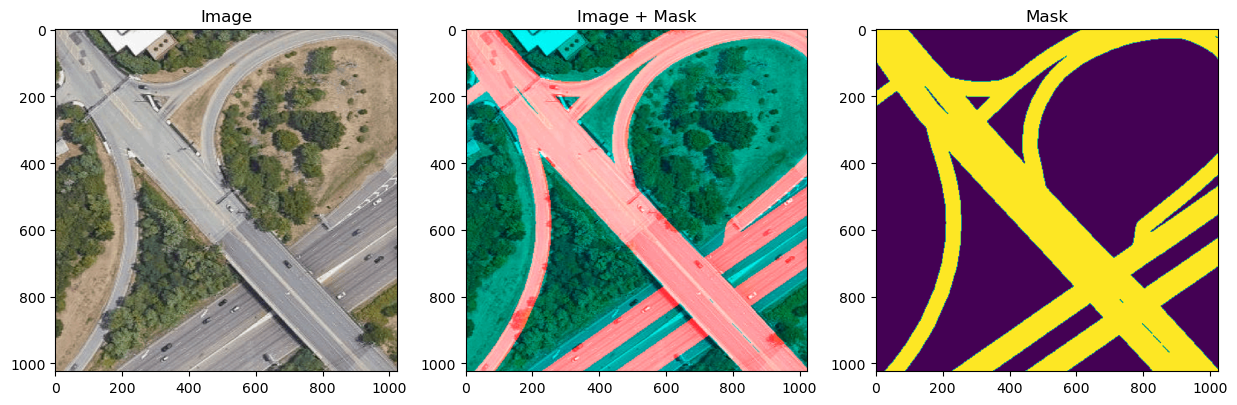

0 255 0.0 1.0


In [3]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
print("img: ",img.shape,img.dtype,img.min(),img.max(),img.mean())
mask2 = (mask * 255.).astype(np.uint8)
print("mask2: ",mask2.shape,mask2.dtype,mask2.min(),mask2.max())
cmb = img
cmb[:,:,0] = mask2[:,:,0]  
print("cmb: ",cmb.shape,cmb.dtype,cmb.min(),cmb.max(),cmb.mean())
plt.imshow(cmb)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()
print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [ ]:
train_split = 0.8


gpu_batch_size = 1

import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

#original_train_dataloader = DataLoader(original_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#original_test_dataloader = DataLoader(original_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
original_dataloader = DataLoader(original_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

#custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
custom_dataloader = DataLoader(custom_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)

## Loading the model

In [ ]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(encoder_option:int, device,decoder,encoder_finetune_num_last_layers=6):
    #
    # encoder_option =0 : for vit_b with the encoder that just retunrs the final block output.
    # encoder_option =1 : for vit_b with the encoder that returns the intermediate outputs + final output.  

    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_b_intermediate"]#,"vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth"] #,"sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[encoder_option]](checkpoint=model_paths[0])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder,encoder_finetune_num_last_layers=encoder_finetune_num_last_layers)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder,encoder_finetune_num_last_layers=6):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_last_layers,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam"):
    #   
    #   decoder_options: ["conv", "mlp" , "segformer_mlp"]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #

    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder.decoder,encoder_finetune_num_last_layers)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "spatial-full":
        decoder = MLP_Decoder_Spatially_Aware(context_option=1)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "spatial-small":
        decoder = MLP_Decoder_Spatially_Aware(context_option=0)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    elif decoder_option == "skip-connect":
        decoder = Skip_MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(1,device,decoder,encoder_finetune_num_last_layers)
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        model.load_state_dict(torch.load(finetune_path+finetuned_model_name+".pth",map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers:
            param.requires_grad = True
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Actually loading the model

In [ ]:
finetuned_model_name = "model_best_so_far.pth"


#model = load_sam_model("mlp",device,encoder_finetune_num_last_layers=0,sam_checkpoint_idx=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="sam")


model = load_sam_model("skip-connect",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="sam")

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

In [ ]:
print(model)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Loss Functions

In [ ]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

def dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = probs.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def combined_loss_1(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return 2 * dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

def combined_loss_2(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

def combined_loss_3(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + 2 * bce_loss(logits_sq, mask_sq)

# Training Loop

# now add the logic 

go over all possible decoder models

train for a few epochs with only few encoder layers unlocked until the last epoch didnt improve the original loss
increase the number of layers finetuned, 
if the whole epoch didnt improve, then stop the training in general

always store the model, start each new layer round with the best of the last or second last stored model. 


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = custom_dataloader
test_loader = original_dataloader


########
max_num_epochs = 3


# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 1
do_intermed_prints = False

grad_batch_size = 5

#########

decoder_options = ["skip-connect","spatial-full","spatial-small"]#["conv", "mlp"]
num_layers_to_finetune = [25,65,85]
learning_rates = [0.001,0.0001, 0.00001]
loss_functions = [combined_loss_1,combined_loss_2,combined_loss_3]

##################################
# TRAINING LOOP
################################

#for loss_fn_idx in range(len(loss_functions)):
loss_fn_idx = 1
for decoder_option in decoder_options:
    for idx_layer_option in range(len(num_layers_to_finetune)):
        for epoch_counter in range(max_num_epochs):
            
            epoch_to_train = epoch_counter
            layer_option = num_layers_to_finetune[idx_layer_option]
            learning_rate = learning_rates[idx_layer_option]
            loss_fn = loss_functions[loss_fn_idx]
            
            #####################################            
            # now training this model 
            current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter}"
            print("training model:",current_model_description)
            # check if this current model description already exists, if so, load the model and skip this exact training step:
            if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                print("model already exists, skipping training for this layer option")
                continue
            # since model was not already trained
            # load the "start model from checkpoint or finetuned"
            # load the initial model from the sam checkpoint
            if idx_layer_option == 0 and epoch_counter == 0:
                print("loading model from sam checkpoint")
                model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=layer_option,finetuned_model_name=None,sam_checkpoint_or_finetuned="sam")
            else:
                
                if epoch_counter == 0:
                    # now epoch 0, hence load max epoch from previous layer option
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{num_layers_to_finetune[idx_layer_option-1]}_epoch_{max_num_epochs-1}"
                else:
                    # load the last epoch from current layer option
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter-1}"
                print("loading model from finetuned:",model_description)
                model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=layer_option,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned")
                
            # newly initializing the optimizer and scheduler since model was loaded new (do this for every epoch:)
            ####################################
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            print("Starting Epoch: ",epoch_counter)
            # training run: 
            model.train()
            # store running losses for the epoch and the 10% print interval
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0

            short_running_loss = 0.0
            short_running_f1 = 0.0

            step_counter = 0
            
            mini_batch_loss_accumulator = 0.0
            
            # reset the gradients: 
            optimizer.zero_grad()
            
            #########################################
            # TRAINING LOOP
            for image, mask in tqdm(train_loader):
                step_counter += 1
                #####################
                # forward pass
                image = image.to(device)
                mask = mask.to(device)    
                pred = model(image)
                # compute loss and f1 score: 
                loss = loss_fn(pred,mask)
                
                
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                short_running_loss += loss.item()
                short_running_f1 += f1_score

                mini_batch_loss_accumulator += loss

                if do_intermed_prints and step_counter % print_interval == 0:
                    print("step: ",step_counter//print_interval)
                    # print out the current losses:
                    print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                    # and reset the short running losses
                    short_running_loss = 0.0
                    short_running_f1 = 0.0

                ###############
                # backward pass
                if step_counter % grad_batch_size == 0:
                    # compute the gradients
                    mini_batch_loss_accumulator = mini_batch_loss_accumulator/grad_batch_size
                    mini_batch_loss_accumulator.backward()
                    # update the model weights
                    optimizer.step()
                    # reset the gradients
                    optimizer.zero_grad()
                    mini_batch_loss_accumulator = 0.0
                
            
            print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
            ########################################
            # save the model in every epoch
            print("saving model:",current_model_description)
            torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth")
            #########################################
            # testing run: 
            model.eval()
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")    

        # save the model after the training run

Now I want to manually finetune each model with another epoch with lower learning rate and more layers to tune

# Analysing the generated models



In [ ]:
decoder_options = ["conv", "mlp"]
num_layers_to_finetune = [65,85]
loss_functions = [combined_loss_1,combined_loss_2,combined_loss_3]
range_epochs = [0,1,2]

##################################
# TESTING LOOP
################################

eval_d_loader = original_dataloader

results_f1 = []
results_loss = []

for loss_fn_idx in range(len(loss_functions)):
    for decoder_option in decoder_options:
        for idx_layer_option in range(len(num_layers_to_finetune)):
            for epoch_counter in range_epochs:
                
                layer_option = num_layers_to_finetune[idx_layer_option]

                
                #####################################            
                # now training this model 
                current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter}"
                print("training model:",current_model_description)
                # check if this current model description already exists, if so, load the model and skip this exact training step:
                if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                    print("model already exists, skipping training for this layer option")
                    
                    
                    
                    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=layer_option,finetuned_model_name=current_model_description,sam_checkpoint_or_finetuned="finetuned")
                    
                    ### TESTING RUN
                    
                    model = model.to(device)
                    model.eval()
                    
                    loss_fn = loss_functions[loss_fn_idx]

                    with torch.no_grad():
                        loss_acc = 0.0
                        f1_acc = 0.0

                        for image,mask in tqdm(eval_d_loader):
                            image = image.to(device)
                            mask = mask.to(device)
                            pred = model(image)
                            # compute loss and f1 score: 
                            score = mean_f1_score_from_logits(pred,mask)
                            loss = loss_fn(pred,mask)

                            f1_acc += score.item()
                            loss_acc  += loss.item() 
                        print(f"(test) Loss: {loss_acc/len(eval_d_loader)}, F1-Score: {f1_acc/len(eval_d_loader)}") 
                    

                    results_f1.append((f1_acc/len(eval_d_loader),current_model_description))
                    results_loss.append((loss_acc/len(eval_d_loader),current_model_description))
                    
                else:
                    print("could not find model")
                
                #
###########################
# now every models score and loss was stored in the results lists
# lets print the best models:

results_f1.sort(key=lambda x: x[0],reverse=True)
results_loss.sort(key=lambda x: x[0])

# print 10 best models and their f1 scores
print("Best F1 models:")
for i in range(10):
    print(results_f1[i])

# print 10 best models and their loss scores
print("Best Loss models:")
for i in range(10):
    print(results_loss[i])           

In [ ]:
# now we test these models submission:


print("Best F1 models:")
for i in range(4):
    print(results_f1[i])
    decoder_option = results_f1[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,finetuned_model_name=results_f1[i][1],sam_checkpoint_or_finetuned="finetuned")
    model.to(device)
    
    model_to_submission(model,submission_dataloader,submission_filename = results_f1[i][1]+"_submission.csv")
#model_to_submission(mlp_model,submission_dataloader,submission_filename =  "mlp_95_1_submission.csv")

# Ensemble Submission of best models

In [ ]:

def ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    all_predictions = []
    for model in model_list:
        model = model.to(device)
        model.eval()
        predictions = []

        with torch.no_grad():
            for image in tqdm(submission_dataloader):
                image = image.to(device)
                pred = model(image)
                predictions.append(pred)
        model = model.to("cpu")
    # check the shape of the predictions
        assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
        all_predictions.append(predictions)
    # go over all predictions and convert the logits to predictions:
    
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    num_models = len(model_list)
    num_images = len(all_predictions[0])
    assert num_images == 144
    
    for img_index in range(num_images):
        
        
        ensemble_image = np.zeros((400,400))
        
        for model_idx in range(num_models):
            pred = all_predictions[model_idx][img_index]
            pred = pred.squeeze()
            # pred is torch vector of shape (1024,1024)
            # convert to image
            pred = torch.round(torch.sigmoid(pred))
            # compress to 400x400
            pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
            #print(pred.shape)
            # pred is now torch vector of shape (1,1,400,400)
            # convert to numpy
            pred = pred.squeeze().squeeze().to("cpu").numpy()
            #print(pred.shape)
            # pred is now numpy vector of shape (400,400)

            # add to initial image
            ensemble_image += pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        ensemble_image = ensemble_image/num_models
        # round the image
        if rounding_policy == "up":
            ensemble_image = np.round(ensemble_image)
        elif rounding_policy == "down":
            ensemble_image = np.floor(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        
        # store as png to disk
        ensemble_image = (ensemble_image * 255).astype(np.uint8)
        # add 2 other color channels
        ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)
    
    
    
print("Best F1 models:")
model_list = []
for i in range(3):
    print(results_f1[i])
    decoder_option = results_f1[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,sam_checkpoint_idx=0,finetuned_model_name=results_f1[i][1],sam_checkpoint_or_finetuned="finetuned")
    model = model.to("cpu")
    # add model to list
    model_list.append(model)
    
# now ensemble the models and create a submission
ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "ensemble_submission_top3_f1_score.csv")

# Loss and F1 of current model on original dataset

In [ ]:
print(model)

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F


sample = original_data_set[10]
inpt_0, gt_0 = sample[0], sample[1]
with torch.no_grad():
    decoder_opt = torch.sigmoid(model(inpt_0.to(device).unsqueeze(0)))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

# Making a Submission: 

First run the model over the submission dataloader, generate all the images. Then transform the 1024x1024 images back to the required format and store them on disk.



In [ ]:
import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)

In [ ]:
model_to_submission(model,submission_dataloader,submission_filename =  "test_submission.csv")

# Show images from submission dataset with their prediction:

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F

 
inpt_0 = submission_data_set[2]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display img2 on the second subplot
axs[0].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[0].axis('off')

# Display img3 on the second subplot
axs[1].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()